# Data

## get data

In [1]:
!wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
!wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat

import scipy.io


import numpy as np
import pandas as pd
from matplotlib import pyplot as p

input = scipy.io.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
labels = scipy.io.loadmat('Indian_pines_gt.mat')['indian_pines_gt']


--2021-01-12 23:49:18--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2021-01-12 23:49:19 (165 MB/s) - ‘Indian_pines_gt.mat’ saved [1125/1125]

--2021-01-12 23:49:19--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M   559KB/s    in 12s     

2021-01-12 23:49:31 (502 KB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]



## process data


In [2]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createPatchs(X, y, patch_size=5, removeZeroLabels = True):
    margin = int((patch_size - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)

    patchesData = np.zeros((X.shape[0] * X.shape[1], patch_size, patch_size, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1 , c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1

    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1

    return patchesData, patchesLabels
    
def featureNormalize(X,type):
    #type==1 x = (x-mean)/std(x)
    #type==2 x = (x-max(x))/(max(x)-min(x))
    if type==1:
        mu = np.mean(X,0)
        X_norm = X-mu
        sigma = np.std(X_norm,0)
        X_norm = X_norm/sigma
        return X_norm
    elif type==2:
        minX = np.min(X,0)
        maxX = np.max(X,0)
        X_norm = X-minX
        X_norm = X_norm/(maxX-minX)
        return X_norm    

In [3]:
## in case of PCA application  uncommente the lines
from sklearn.decomposition import PCA

k = 200
x_t = input
#x_t = np.reshape(input, (-1, input.shape[2]))
#pca = PCA(n_components=k, whiten=True)
#x_t = pca.fit_transform(x_t)
#x_t = np.reshape(x_t, (input.shape[0],input.shape[1], k))

print(x_t.shape)

(145, 145, 200)


In [4]:
# patch size is the window size for patch based classification 
patch_size = 7
patched_x, patched_y = createPatchs(x_t,labels,patch_size,True)

In [5]:
# if you want to use larger patch sizes ( > 40 ) go with this algorithm instead of the above cell ( comment the above cell, for large patchs u can run out of RAM ) 
# this algorithme can cost you some data loss though

import os 
'''
if os.path.exists("patched_x.npy") : 
  patched_x = np.load("patched_x.npy")
  patched_y = np.load("patched_y.npy")
else :  

  patched_x = np.array([])
  patched_y = np.array([])
  cut_size = 2

  for i in range(0,x_t.shape[0]-patch_size,patch_size) : 
    for j in range(0,x_t.shape[1],x_t.shape[1]//cut_size) : 
      if j + x_t.shape[1]//2 < x_t.shape[1] : 
        patched_x_t, patched_y_t = createPatchs(x_t[i:i+patch_size,j:j+x_t.shape[1]//cut_size,:],labels[i:i+patch_size,j:j+x_t.shape[1]//cut_size],patch_size,True)
        print(i)
        if i == 0 and j == 0 : 
          patched_x = patched_x_t
          patched_y = patched_y_t
        else : 
          patched_x = np.concatenate([patched_x,patched_x_t],axis=0)
          patched_y = np.concatenate([patched_y,patched_y_t],axis=0)
'''          

'\nif os.path.exists("patched_x.npy") : \n  patched_x = np.load("patched_x.npy")\n  patched_y = np.load("patched_y.npy")\nelse :  \n\n  patched_x = np.array([])\n  patched_y = np.array([])\n  cut_size = 2\n\n  for i in range(0,x_t.shape[0]-patch_size,patch_size) : \n    for j in range(0,x_t.shape[1],x_t.shape[1]//cut_size) : \n      if j + x_t.shape[1]//2 < x_t.shape[1] : \n        patched_x_t, patched_y_t = createPatchs(x_t[i:i+patch_size,j:j+x_t.shape[1]//cut_size,:],labels[i:i+patch_size,j:j+x_t.shape[1]//cut_size],patch_size,True)\n        print(i)\n        if i == 0 and j == 0 : \n          patched_x = patched_x_t\n          patched_y = patched_y_t\n        else : \n          patched_x = np.concatenate([patched_x,patched_x_t],axis=0)\n          patched_y = np.concatenate([patched_y,patched_y_t],axis=0)\n'

## Prepare for Deep learning 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold

x_train = []
y_train = []
x_test = []
y_test = []
x_val = []
y_val = []

# 90% test, 10% training
rs = ShuffleSplit(n_splits=1, test_size=.90, random_state=42)

# keep the indexs for further use ( to map the classification map )
for train_index, test_index in rs.split(patched_x):
        x_train.append(patched_x[train_index])
        x_test.append(patched_x[test_index])
        
for train_index, test_index in rs.split(patched_y):
        y_train.append(patched_y[train_index])
        y_test.append(patched_y[test_index])



In [7]:
x_train = np.asarray(x_train)[0]
y_train = np.asarray(y_train)[0]
x_test = np.asarray(x_test)[0]
y_test = np.asarray(y_test)[0]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(1024, 7, 7, 200)
(9225, 7, 7, 200)
(1024,)


In [8]:
# validation set
_,x_val, _,y_val = train_test_split(x_test,y_test,test_size=0.20,random_state=70)

In [9]:
from keras import utils
from keras.datasets import mnist
from keras.models import Model
from keras.layers import *
from keras import backend as K
import tensorflow as tf



x_train = np.reshape(x_train,(-1,x_train.shape[1],x_train.shape[2],x_train.shape[3]))
x_test = np.reshape(x_test,(-1,x_test.shape[1],x_test.shape[2],x_test.shape[3]))
x_val = np.reshape(x_val,(-1,x_val.shape[1],x_val.shape[2],x_val.shape[3]))
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)


# map

     |████████████████████████████████| 215kB 10.5MB/s 


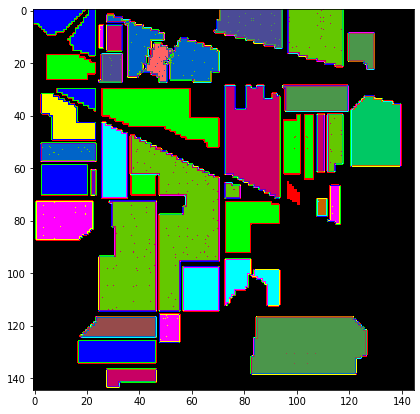

In [11]:
!pip install spectral
import spectral 

ground_truth = spectral.imshow(classes = labels,figsize =(7,7))